<a href="https://colab.research.google.com/github/yurigalindo/DeepLearningMeteors/blob/master/Threshold_splits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip /content/gdrive/My\ Drive/csvs.zip -d csvs


Archive:  /content/gdrive/My Drive/csvs.zip
  inflating: csvs/__Mdates0test.csv  
  inflating: csvs/__Mdates0train.csv  
  inflating: csvs/__Mdates1test.csv  
  inflating: csvs/__Mdates1train.csv  
  inflating: csvs/__Mdates2test.csv  
  inflating: csvs/__Mdates2train.csv  
  inflating: csvs/__Mdates3test.csv  
  inflating: csvs/__Mdates3train.csv  
  inflating: csvs/__Mdates4test.csv  
  inflating: csvs/__Mdates4train.csv  
  inflating: csvs/__Mplacedates0test.csv  
  inflating: csvs/__Mplacedates0train.csv  
  inflating: csvs/__Mplacedates1test.csv  
  inflating: csvs/__Mplacedates1train.csv  
  inflating: csvs/__Mplacedates2test.csv  
  inflating: csvs/__Mplacedates2train.csv  
  inflating: csvs/__Mplacedates3test.csv  
  inflating: csvs/__Mplacedates3train.csv  
  inflating: csvs/__Mplacedates4test.csv  
  inflating: csvs/__Mplacedates4train.csv  
  inflating: csvs/__Mplaces0test.csv  
  inflating: csvs/__Mplaces0train.csv  
  inflating: csvs/__Mplaces1test.csv  
  inflating: csvs/

In [0]:
!unzip /content/gdrive/My\ Drive/Mix.zip -d mixedCaptures

Archive:  /content/gdrive/My Drive/Mix.zip
   creating: mixedCaptures/Meteoros/
  inflating: mixedCaptures/Meteoros/M20180101_030747_FFD_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20180108_013859_FFD_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20180109_002140_FFD_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_035622_OMC_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_040322_GBS_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_041719_OMC_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_043018_OMC_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_045057_ITU_2P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_050735_ITU_2P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_051235_SJU_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_051820_ITU_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_052259_RJK_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_052302_GBS_1P.jpg  
  inflating: mixedCaptures/Meteoros/M20170321_052749_VIX_2P.jp

In [0]:
from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
import os
import os.path
from torch.utils.data import Dataset
from torchvision import get_image_backend

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def default_loader(path):
  if get_image_backend() == 'accimage':
    return accimage_loader(path)
  else:
    return pil_loader(path)
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
      return pil_loader(path)

class ImageFromCSV(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.csv.iloc[idx, 0])
        image = default_loader(img_name)
        label = self.csv.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image , label

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomOrder([
          transforms.Resize((350,350))
          #transforms.RandomHorizontalFlip(),
          #transforms.RandomRotation(45),
          #transforms.RandomVerticalFlip()
          ]
        ),
        transforms.ColorJitter(0.5,0.5,0.5,0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((420,420)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'mixedCaptures'
image_datasets = dict()

for split in ['__Mdates','__Mplaces']:
  
  image_datasets[split] =  {x + f'{i}': ImageFromCSV("csvs/{0}{1}{2}.csv".format(split,i,x),"mixedCaptures/Meteoros",transform=data_transforms[x])
                  for i in range(5) for x in ['train','test']}


In [0]:
print(image_datasets)

{'shuffle': {'train0': <__main__.ImageFromCSV object at 0x7f6e94695860>, 'test0': <__main__.ImageFromCSV object at 0x7f6efa3dfc50>, 'train1': <__main__.ImageFromCSV object at 0x7f6e94bc9b00>, 'test1': <__main__.ImageFromCSV object at 0x7f6e946979b0>, 'train2': <__main__.ImageFromCSV object at 0x7f6e94697a20>, 'test2': <__main__.ImageFromCSV object at 0x7f6e94697b38>, 'train3': <__main__.ImageFromCSV object at 0x7f6e94697c50>, 'test3': <__main__.ImageFromCSV object at 0x7f6e94697d68>, 'train4': <__main__.ImageFromCSV object at 0x7f6e94697e80>, 'test4': <__main__.ImageFromCSV object at 0x7f6e94697f98>}}


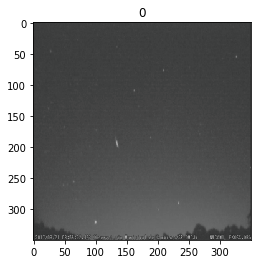

In [0]:
dataloader=torch.utils.data.DataLoader(image_datasets['shuffle']['train0'])
plt.ion() 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

#print(inputs)
#print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes.item())
#del dataloader

In [0]:
import matplotlib.pyplot as plt
import torch

class Learner:
    def __init__(self,model,criterion):
        self.model=model
        self.criterion=criterion
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_acc=0
        self.last_acc=0

    def set_datasets(self,training,valid):
        self.training_dataset=training
        self.validation_dataset=valid
    def set_optimizer(self,optimizer,scheduler):
        self.optimizer=optimizer
        self.scheduler=scheduler
    def propagate_batch(self,inputs,labels):
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            size=inputs.size(0)
            del inputs
            loss = self.criterion(outputs, labels)
            #loss.requires_grad=True
            loss.backward()
            
        with torch.no_grad():
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item() 
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del labels
        return loss_item*size,corrects

    def eval_batch(self, inputs, labels):
        with torch.no_grad():
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del outputs
        del loss
        del preds
        del inputs
        del labels
        return loss_item*size,corrects

    def print_statistics(self,loss,accuracy):
        print("  Avg Loss={}\n  Accuracy={}".format(loss,accuracy))
    def ceildiv(self,a, b):
        """Return the celing of the division of a by b
        """
        return -(-a // b)
    def min_value(self,a,b):
        """Return the smaller of two values
        """
        if a>b:
            return b
        else:
            return a
    def max_value(self,a,b):
        """"Return the greater of two values
        """
        if b>a:
          return b
        else:
          return a
    def change_to_best_model(self):
        self.model.load_state_dict(self.best_model_wts)
    def train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=32):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        batch_cap=self.min_value(training_batchsize,batch_cap)
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=batch_cap,shuffle=True)
        
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        micro_batches=training_batchsize//batch_cap #accuracy statistics will only work properly if training batch is divisible by batch_cap
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        for epoch in range(num_epochs):
            print("Epoch {} of {}".format(epoch,num_epochs-1))
            
            

            self.model.train()
            #Train model
            loss = 0
            corrects = 0
            iterator = iter(train_dataloader)
            #for batch in range(training_batches):
            for batch in range(training_batches):
                self.optimizer.zero_grad()
                try:
                  for micro_batch in range(micro_batches):

                    inputs,labels=next(iterator)
                    new_loss , new_corrects = self.propagate_batch(inputs.to(self.device),labels.to(self.device))
                    loss+=new_loss
                    corrects+=new_corrects
                    del inputs
                    del labels
                    del new_loss
                    del new_corrects
                    torch.cuda.empty_cache()
                except StopIteration:
                    pass
                self.optimizer.step()
                torch.cuda.empty_cache()

            self.scheduler.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()
            train_losses.append(loss/len(self.training_dataset))
            print("Training:")
            self.print_statistics(loss/len(self.training_dataset),corrects/len(self.training_dataset))
            
            
            self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            valid_losses.append(loss/len(self.validation_dataset))
            acc=corrects/len(self.validation_dataset)
            print("Validation:")
            self.print_statistics(loss/len(self.validation_dataset),acc)
            print()
            self.last_acc=acc
            if(acc>self.best_acc):
              self.best_acc=acc
              self.best_model_wts = copy.deepcopy(self.model.state_dict())
            

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
    def predict(self,dataset,batchsize,num_classes):
        """Return a tensor containing the probabilities of each class
        """
        dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
        dataset_len=len(dataset)
        num_batches=self.ceildiv(dataset_len,batchsize)
        since = time.time()
        predictions = torch.zeros((len(dataset),num_classes)).to(self.device)
        #for layer in self.model.children():  
        #  if isinstance(layer, nn.BatchNorm2d):
        #    layer.eval()
        self.model.eval()
        self.optimizer.zero_grad()
        #self.model.train()
        iterator = iter(dataloader)
        with torch.no_grad():
          for batch in range(num_batches):
              inputs, _ = next(iterator)
              inputs = inputs.to(self.device)
              logits =  self.model(inputs)
              del inputs
              unnormalized_probabilities = torch.exp(logits)
              del logits
              denominators = torch.sum(unnormalized_probabilities,1,True)
              probabilities= torch.div(unnormalized_probabilities,denominators)
              del denominators
              del unnormalized_probabilities
              indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
              predictions.index_copy_(0,indexes,probabilities)
              del indexes
              del probabilities
              torch.cuda.empty_cache()
          predictions_cpu=predictions.cpu()
        del predictions
        del dataloader
        torch.cuda.empty_cache()
        return predictions_cpu

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class FlattenTo1d(nn.Module):
    def __init__(self,num_classes):
        self.n=num_classes
        super(FlattenTo1d, self).__init__()

    def forward(self, x):
       return x.view(-1,self.n)


In [0]:
def acc_for_threshold(predictions,labels,threshold):
  #Threshold must be smaller than 0.5
  threshold = min(threshold,1-threshold)
  predicted=0
  correct = 0
  meteors = 0
  tp=fp=tn=fn=0
  for i in range(len(predictions)):
    item = predictions[i].item()
    if threshold>=item or item>=1-threshold:
      predicted+=1

      if abs(labels[i] - item)<=0.5:
        correct+=1
        if labels[i]==0:
          meteors+=1
          tp+=1
        else:
          tn+=1
      else:
        if labels[i]==0:
          fn+=1
        else:
          fp+=1
  if predicted == 0:
    return {'acc':0,'meteor_ratio':0,'coverage':0}
  return {'acc':correct/float(predicted),'meteor_ratio':meteors/float(predicted),'coverage':predicted/float(len(predictions)),'precision':tp/float(tp+fp) if tp else 0,'recall':tp/float(tp+fn) if tp else 0}

__Mdates
fold0
Epoch 0 of 2
Training:
  Avg Loss=0.22353052990720282
  Accuracy=0.912568306010929
Validation:
  Avg Loss=0.43134610114091804
  Accuracy=0.7995139732685298

Epoch 1 of 2
Training:
  Avg Loss=0.10183630545771187
  Accuracy=0.9678202792956891
Validation:
  Avg Loss=0.31144440615886904
  Accuracy=0.9161603888213852

Epoch 2 of 2
Training:
  Avg Loss=0.07289681825096961
  Accuracy=0.9735883424408015
Validation:
  Avg Loss=0.29114328685102314
  Accuracy=0.9076549210206561

Total time:479.9766707420349
ACC for threshold
0.01
{'acc': 0.9347826086956522, 'meteor_ratio': 0.5217391304347826, 'coverage': 0.05589307411907655}

0.05
{'acc': 0.9665071770334929, 'meteor_ratio': 0.5741626794258373, 'coverage': 0.25394896719319565}

0.1
{'acc': 0.969309462915601, 'meteor_ratio': 0.48081841432225064, 'coverage': 0.47509113001215064}

0.3
{'acc': 0.9491525423728814, 'meteor_ratio': 0.4435028248587571, 'coverage': 0.8602673147023087}

0.51
{'acc': 0.9096459096459096, 'meteor_ratio': 0.44322

KeyboardInterrupt: ignored

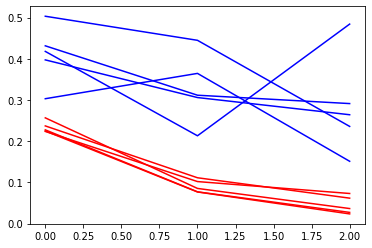

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#accuracies = {x:[] for x in ['placedates','all','places']}
#for split in ['placedates','all','places']:
#statistics = {x:[] for x in image_datasets}
for split in ['__Mplaces']:
  print(split)
  for i in range(5):
    print(f"fold{i}")
    model_ft = models.resnet50(pretrained=True)
    model_ft=nn.Sequential(
        model_ft.conv1,
        model_ft.bn1,
        model_ft.relu,
        model_ft.maxpool,
        model_ft.layer1,
        model_ft.layer2,
        model_ft.layer3,
        model_ft.layer4,
        nn.Dropout(0.5),
        nn.Conv2d(2048,2,1), #256 for alexnet
        nn.AdaptiveAvgPool2d(1),
        FlattenTo1d(2)
    )
    model_ft=model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    learner = Learner(model_ft,criterion)

    optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
    learner.set_optimizer(optimizer,scheduler)

    learner.set_datasets(image_datasets[split][f'train{i}'],image_datasets[split][f'test{i}'])
    learner.train(3,64,128,batch_cap=32)
    #accuracies[split].append(learner.last_acc)

    predictions = learner.predict(image_datasets[split][f'test{i}'],32,2)
    summarized = predictions [: , 1]
    labels = [image_datasets[split][f'test{i}'][j][1] for j in range(len(image_datasets[split][f'test{i}']))]

    print ("ACC for threshold")
    for threshold in [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.51]:
      print(threshold)
      print(acc_for_threshold(summarized,labels,threshold))
      print()
  
  print()

__Mplaces
fold0
Epoch 0 of 2
Training:
  Avg Loss=0.26309544686259384
  Accuracy=0.8909458094917536
Validation:
  Avg Loss=0.7998560532849497
  Accuracy=0.4232111692844677

Epoch 1 of 2
Training:
  Avg Loss=0.042575274060600354
  Accuracy=0.987882867721306
Validation:
  Avg Loss=0.4079983599002865
  Accuracy=0.8917975567190227

Epoch 2 of 2
Training:
  Avg Loss=0.02075108996200937
  Accuracy=0.995287781891619
Validation:
  Avg Loss=0.6757472796173828
  Accuracy=0.5698080279232112

Total time:476.44777750968933
ACC for threshold
0.01
{'acc': 1.0, 'meteor_ratio': 0.9607843137254902, 'coverage': 0.08900523560209424}

0.05
{'acc': 0.9785714285714285, 'meteor_ratio': 0.9357142857142857, 'coverage': 0.2443280977312391}

0.1
{'acc': 0.9491978609625669, 'meteor_ratio': 0.8983957219251337, 'coverage': 0.3263525305410122}

0.3
{'acc': 0.6540880503144654, 'meteor_ratio': 0.5094339622641509, 'coverage': 0.693717277486911}

0.51
{'acc': 0.5701676963812886, 'meteor_ratio': 0.36540158870255957, 'cove

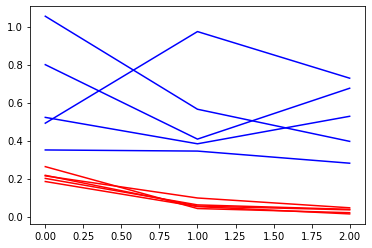

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#accuracies = {x:[] for x in ['placedates','all','places']}
#for split in ['placedates','all','places']:
#statistics = {x:[] for x in image_datasets}
for split in ['__Mplaces']:
  print(split)
  for i in range(5):
    print(f"fold{i}")
    model_ft = models.resnet50(pretrained=True)
    model_ft=nn.Sequential(
        model_ft.conv1,
        model_ft.bn1,
        model_ft.relu,
        model_ft.maxpool,
        model_ft.layer1,
        model_ft.layer2,
        model_ft.layer3,
        model_ft.layer4,
        nn.Dropout(0.5),
        nn.Conv2d(2048,2,1), #256 for alexnet
        nn.AdaptiveAvgPool2d(1),
        FlattenTo1d(2)
    )
    model_ft=model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    learner = Learner(model_ft,criterion)

    optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
    learner.set_optimizer(optimizer,scheduler)

    learner.set_datasets(image_datasets[split][f'train{i}'],image_datasets[split][f'test{i}'])
    learner.train(3,64,128,batch_cap=32)
    #accuracies[split].append(learner.last_acc)

    predictions = learner.predict(image_datasets[split][f'test{i}'],32,2)
    summarized = predictions [: , 1]
    labels = [image_datasets[split][f'test{i}'][j][1] for j in range(len(image_datasets[split][f'test{i}']))]

    print ("ACC for threshold")
    for threshold in [0.01,0.05,0.1,0.3,0.51]:
      print(threshold)
      print(acc_for_threshold(summarized,labels,threshold))
      print()
  
  print()

__Mplaces
fold0
Epoch 0 of 2
Training:
  Avg Loss=0.2344708464856663
  Accuracy=0.9108044429485022
Validation:
  Avg Loss=0.3251648305494332
  Accuracy=0.8726003490401396

Epoch 1 of 2
Training:
  Avg Loss=0.0582730414790049
  Accuracy=0.9811511275664759
Validation:
  Avg Loss=0.25668581607662155
  Accuracy=0.9223385689354275

Epoch 2 of 2
Training:
  Avg Loss=0.015753574239278794
  Accuracy=0.996634129922585
Validation:
  Avg Loss=0.16674255711037866
  Accuracy=0.9546247818499127

Total time:383.22561264038086
ACC for threshold
0.1
{'acc': 0.9938195302843016, 'meteor_ratio': 0.2311495673671199, 'coverage': 0.705933682373473, 'precision': 0.9946808510638298, 'recall': 0.9790575916230366}

fold1
Epoch 0 of 2
Training:
  Avg Loss=0.19368783395602707
  Accuracy=0.9276822762299941
Validation:
  Avg Loss=0.4754453112106785
  Accuracy=0.8317631224764468

Epoch 1 of 2
Training:
  Avg Loss=0.05744023711951124
  Accuracy=0.9845880260818021
Validation:
  Avg Loss=0.51475699536733
  Accuracy=0.74

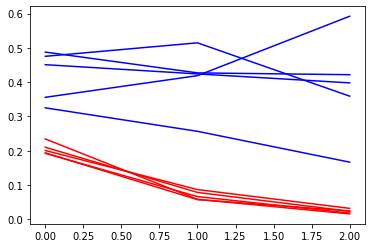

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#accuracies = {x:[] for x in ['placedates','all','places']}
#for split in ['placedates','all','places']:
#statistics = {x:[] for x in image_datasets}
for split in ['__Mplaces']:
  print(split)
  for i in range(5):
    print(f"fold{i}")
    model_ft = models.resnet50(pretrained=True)
    model_ft=nn.Sequential(
        model_ft.conv1,
        model_ft.bn1,
        model_ft.relu,
        model_ft.maxpool,
        model_ft.layer1,
        model_ft.layer2,
        model_ft.layer3,
        model_ft.layer4,
        nn.Dropout(0.5),
        nn.Conv2d(2048,2,1), #256 for alexnet
        nn.AdaptiveAvgPool2d(1),
        FlattenTo1d(2)
    )
    model_ft=model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    learner = Learner(model_ft,criterion)

    optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
    learner.set_optimizer(optimizer,scheduler)

    learner.set_datasets(image_datasets[split][f'train{i}'],image_datasets[split][f'test{i}'])
    learner.train(3,64,128,batch_cap=32)
    #accuracies[split].append(learner.last_acc)

    predictions = learner.predict(image_datasets[split][f'test{i}'],32,2)
    summarized = predictions [: , 1]
    labels = [image_datasets[split][f'test{i}'][j][1] for j in range(len(image_datasets[split][f'test{i}']))]

    print ("ACC for threshold")
    for threshold in [0.1]:
      print(threshold)
      print(acc_for_threshold(summarized,labels,threshold))
      print()
  
  print()

In [0]:
for split in accuracies:
  print(split)
  print(accuracies[split])

dates_
[0.7229647630619684, 0.9295261239368166, 0.8578371810449574, 0.9270959902794653, 0.8941605839416058]


Epoch 0 of 2
Training:
  Avg Loss=0.2087971724809555
  Accuracy=0.9098360655737705
Validation:
  Avg Loss=0.4771060427223057
  Accuracy=0.7594167679222357

Epoch 1 of 2
Training:
  Avg Loss=0.11033137334916689
  Accuracy=0.9608378870673953
Validation:
  Avg Loss=0.2769536688869518
  Accuracy=0.8869987849331713

Epoch 2 of 2
Training:
  Avg Loss=0.07333302508833811
  Accuracy=0.9738919247115968
Validation:
  Avg Loss=0.21671209783991516
  Accuracy=0.9307411907654921

Total time:405.63235664367676
Epoch 0 of 4
Training:
  Avg Loss=0.5535353357747025
  Accuracy=0.7027929568913176
Validation:
  Avg Loss=0.6142048085445622
  Accuracy=0.7691373025516404

Epoch 1 of 4
Training:
  Avg Loss=0.43619028434075946
  Accuracy=0.7902246508803886
Validation:
  Avg Loss=0.628268887973498
  Accuracy=0.6597812879708383

Epoch 2 of 4
Training:
  Avg Loss=0.3659885232927731
  Accuracy=0.8479052823315119
Validation:
  Avg Loss=0.5798033745291746
  Accuracy=0.707168894289186

Epoch 3 of 4
Training:
  Avg Los

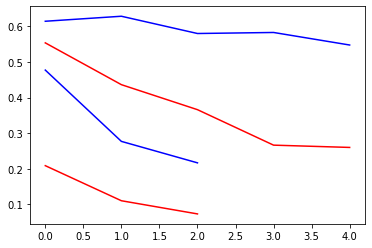

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(5)
  model_ft = models.resnet50(pretrained=True)
  model_ft=nn.Sequential(
      model_ft.conv1,
      model_ft.bn1,
      model_ft.relu,
      model_ft.maxpool,
      model_ft.layer1,
      model_ft.layer2,
      model_ft.layer3,
      model_ft.layer4,
      nn.Dropout(0.5),
      nn.Conv2d(2048,2,1), #256 for alexnet
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )
  model_ft=model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  learner = Learner(model_ft,criterion)

  optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[f'train0'],image_datasets[f'test0'])
  learner.train(3,64,128,batch_cap=32)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      
  import collections

  model_ft = models.alexnet(pretrained=True)

  newFeatures=collections.OrderedDict()
  c=0
  d=0
  for layer in iter(model_ft.features):
    #print(layer)
    a=f'{c}' + '-' + f'{d}'
    d+=1
    newFeatures[a]=layer
    if isinstance(layer,nn.Conv2d):
      a=f'{c}' + '-' + f'{d}'
      newFeatures[a]=nn.Dropout(0.5)
      d+=1
    if isinstance(layer,nn.MaxPool2d):
      c+=1
      d=0
  features=nn.Sequential(newFeatures)
  features=nn.Sequential(
      features,
      nn.Conv2d(256,2,1), #2048 for resnet50
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )

  model_ft=features.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  learner_u = UncertaintyLearner(model_ft,criterion)

  optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner_u.set_optimizer(optimizer,scheduler)

  learner_u.set_datasets(image_datasets[f'train0'],image_datasets[f'test0'])
  learner_u.train(5,64,128,batch_cap=32)

Epoch 0 of 1
Training:
  Avg Loss=0.2274989528716081
  Accuracy=0.9128718882817244
Validation:
  Avg Loss=0.5255719615940915
  Accuracy=0.7776427703523694

Epoch 1 of 1
Training:
  Avg Loss=0.20142964546471998
  Accuracy=0.9250151791135398
Validation:
  Avg Loss=0.5230219607509645
  Accuracy=0.7521263669501823

Total time:151.99811482429504


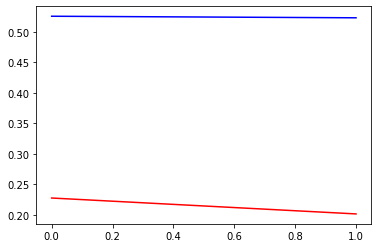

In [0]:
learner_u.train(2,64,128,batch_cap=32)

In [0]:
predictions = learner.predict(image_datasets[f'test0'],32,2)
predictions_u = learner_u.predict(image_datasets[f'test0'],32,2,50)

In [0]:
print(predictions)
print(predictions_u)

tensor([[9.8206e-01, 1.7941e-02],
        [9.7452e-01, 2.5475e-02],
        [9.6879e-01, 3.1212e-02],
        ...,
        [9.5498e-04, 9.9904e-01],
        [9.7604e-04, 9.9902e-01],
        [1.0108e-03, 9.9899e-01]])
tensor([[[7.6175e-01, 2.3825e-01],
         [8.3263e-01, 1.6737e-01],
         [9.9936e-01, 6.4347e-04],
         ...,
         [2.6453e-10, 1.0000e+00],
         [7.1754e-09, 1.0000e+00],
         [9.2659e-10, 1.0000e+00]],

        [[7.9428e-01, 2.0572e-01],
         [7.8676e-01, 2.1324e-01],
         [9.8261e-01, 1.7393e-02],
         ...,
         [1.0624e-10, 1.0000e+00],
         [9.7539e-10, 1.0000e+00],
         [3.7424e-10, 1.0000e+00]],

        [[8.4191e-01, 1.5809e-01],
         [8.5459e-01, 1.4541e-01],
         [9.9990e-01, 9.5176e-05],
         ...,
         [2.2439e-10, 1.0000e+00],
         [7.7777e-10, 1.0000e+00],
         [3.7751e-10, 1.0000e+00]],

        ...,

        [[3.1757e-01, 6.8243e-01],
         [8.1877e-01, 1.8123e-01],
         [9.9646e-01

In [0]:
summarized = predictions [: , 1]
label_evaluation=torch.argmax(predictions_u, dim=2)
summarized_u =(label_evaluation==1).sum(dim=0)
summarized_u = summarized_u/50.
print(summarized)
print(summarized_u) 

tensor([1.7941e-02, 2.5475e-02, 3.1212e-02, 3.4977e-03, 6.8989e-02, 5.9258e-02,
        3.2564e-03, 1.7198e-02, 3.5407e-02, 7.3112e-03, 5.7916e-03, 1.6222e-02,
        1.1820e-02, 1.4949e-01, 1.4500e-02, 3.2542e-02, 4.4756e-02, 1.2775e-01,
        3.1186e-02, 1.6701e-03, 7.5208e-02, 8.1827e-02, 4.0497e-01, 1.9178e-02,
        2.1260e-02, 4.9899e-02, 3.5980e-03, 1.8442e-01, 8.2179e-02, 3.2491e-03,
        2.7104e-01, 3.5508e-03, 5.0702e-01, 4.3205e-01, 1.3221e-04, 2.2976e-02,
        2.2652e-01, 1.1156e-02, 3.7195e-01, 5.2331e-02, 3.1992e-02, 1.3687e-02,
        7.9195e-03, 1.2670e-03, 1.5187e-02, 1.3202e-02, 2.2000e-02, 2.7803e-02,
        9.0483e-02, 6.7792e-01, 1.7877e-01, 6.2122e-02, 1.6621e-02, 3.6046e-02,
        2.2961e-01, 5.5404e-01, 1.2966e-02, 2.2328e-02, 9.3132e-02, 8.0283e-03,
        1.1289e-01, 8.3011e-03, 2.9115e-01, 3.9530e-03, 1.1267e-02, 3.0101e-02,
        2.3906e-01, 2.3813e-02, 5.9671e-03, 4.0989e-02, 8.0172e-02, 4.3419e-02,
        8.0418e-03, 4.6274e-02, 1.1608e-

In [0]:
def acc_for_threshold(predictions,labels,threshold):
  #Threshold must be smaller than 0.5
  threshold = min(threshold,1-threshold)
  total = 0
  correct = 0
  meteors = 0
  for i in range(len(predictions)):
    item = predictions[i].item()
    if threshold>=item or item>=1-threshold:
      total+=1
    
      if abs(labels[i] - item)<=0.5:
        correct+=1
        if labels[i]==0:
          meteors+=1
  return correct/float(total),meteors/float(total)


In [0]:
labels=[image_datasets[f'test0'][j][1] for j in range(len(image_datasets[f'test0']))]

In [0]:
for threshold in range (0.1,0.4,0.1):
  print(acc_for_threshold(summarized_u,labels,threshold))
print(acc_for_threshold(summarized_u,labels,0.05))

(0.8154506437768241, 0.48068669527896996)


Fold 0:
Epoch 0 of 19
Training:
  Avg Loss=0.7733059271256274
  Accuracy=0.6387370977534912
Validation:
  Avg Loss=0.680839940308076
  Accuracy=0.4957472660996355

Epoch 1 of 19
Training:
  Avg Loss=0.5285037334173754
  Accuracy=0.7197935640558591
Validation:
  Avg Loss=0.6602717808935507
  Accuracy=0.5589307411907655

Epoch 2 of 19
Training:
  Avg Loss=0.4973148608576839
  Accuracy=0.7553126897389193
Validation:
  Avg Loss=0.6524443788632732
  Accuracy=0.6136087484811664

Epoch 3 of 19
Training:
  Avg Loss=0.434804994316628
  Accuracy=0.8114754098360656
Validation:
  Avg Loss=0.6279969760742975
  Accuracy=0.6986634264884569

Epoch 4 of 19
Training:
  Avg Loss=0.37256798540814834
  Accuracy=0.852762598664238
Validation:
  Avg Loss=0.6250688110637781
  Accuracy=0.7484811664641555

Epoch 5 of 19
Training:
  Avg Loss=0.3764723998239421
  Accuracy=0.8463873709775349
Validation:
  Avg Loss=0.6308869016271895
  Accuracy=0.7922235722964763

Epoch 6 of 19
Training:
  Avg Loss=0.383967559619534

KeyboardInterrupt: ignored

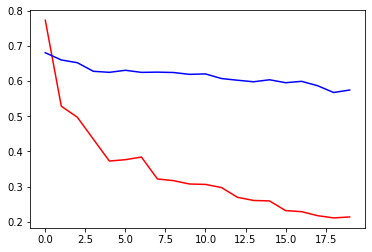

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
import collections

for i in range(5):
  model_ft = models.alexnet(pretrained=True)

  newFeatures=collections.OrderedDict()
  c=0
  d=0
  for layer in iter(model_ft.features):
    #print(layer)
    a=f'{c}' + '-' + f'{d}'
    d+=1
    newFeatures[a]=layer
    if isinstance(layer,nn.Conv2d):
      a=f'{c}' + '-' + f'{d}'
      newFeatures[a]=nn.Dropout(0.7)
      d+=1
    if isinstance(layer,nn.MaxPool2d):
      c+=1
      d=0
  features=nn.Sequential(newFeatures)
  features=nn.Sequential(
      features,
      nn.Conv2d(256,2,1), #2048 for resnet50
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )
  model_ft=features.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  learner = UncertaintyLearner(model_ft,criterion)

  optimizer = optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[f'train{i}'],image_datasets[f'test{i}'])
  print(f'Fold {i}:')
  learner.train(20,64,128,batch_cap=32)
  learner.change_to_best_model()
  predictions = learner.predict(image_datasets[f'test{i}'],32,2,100)
  labels = [image_datasets[f'test{i}'][j][1] for j in range(len(image_datasets[f'test{i}']))]
  label_evaluation=torch.argmax(predictions, dim=2)
  summarized_u =(label_evaluation==1).sum(dim=0)
  summarized_u = summarized_u/100.
  for threshold in range (1,6):
    print(acc_for_threshold(summarized_u,labels,threshold/10.))


In [0]:
def confusion_matrix_u(predictions,true_labels,threshold=100):
  
  TP=FP=TN=FN=PASSED=0
  label_evaluation=torch.argmax(predictions, dim=2)
  #print(label_evaluation.size())
  predicted_labels =(label_evaluation==1).sum(dim=0)
  #print(predicted_labels)
  #should take in account the number of evals
  #print(predicted_labels.size())
  for i in range(len(predicted_labels)):
    if(predicted_labels[i]<=5):
      if(true_labels[i]==0):
        TP+=1
      else:
        FP+=1
    elif(predicted_labels[i]>=35):
      if(true_labels[i]==1):
        TN+=1
      else:
        FN+=1
    else:
      PASSED+=1
  print("TP: {0} FP: {1}".format(TP,FP))
  print("FN: {0} TN: {1}".format(FN,TN))
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1=2*precision*recall/(precision+recall)
  acc=(TP+TN)/(TP+TN+FP+FN)
  print("precision:{0},recall:{1},F1:{2},acc:{3},coverage:{4}".format(precision,recall,F1,acc,1-(PASSED/(TP+TN+FP+FN))))

In [0]:
learner.train(1,64,128,batch_cap=32)
learner_u.train(1,64,128,batch_cap=32)

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
for i in range(1):
  model_ft = models.resnet50(pretrained=True)
  """model_ft=nn.Sequential(
      model_ft.features,
      nn.Conv2d(2048,2,1), #256 for alexnet
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )"""
  model_ft=nn.Sequential(
      model_ft.conv1,
      model_ft.bn1,
      model_ft.relu,
      model_ft.maxpool,
      model_ft.layer1,
      model_ft.layer2,
      model_ft.layer3,
      model_ft.layer4,
      nn.Conv2d(2048,2,1), #256 for alexnet
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )
  model_ft=model_ft.to(device)
  criterion = nn.CrossEntropyLoss()
  learner = Learner(model_ft,criterion)

  optimizer = optim.Adam(model_ft.parameters(), lr = 3e-4)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[f'train{i}'],image_datasets[f'test{i}'])
  print(f'{i}fold')
  learner.train(3,64,128,batch_cap=32)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s] 


0fold
Epoch 0 of 2


KeyboardInterrupt: ignored

In [0]:
def confusion_matrix(predictions,true_labels):
  
  TP=FP=TN=FN=PASSED=0
  label_evaluation=torch.argmax(predictions, dim=2)
  #print(label_evaluation.size())
  predicted_labels =(label_evaluation==1).sum(dim=0)
  #print(predicted_labels)
  #should take in account the number of evals
  #print(predicted_labels.size())
  for i in range(len(predicted_labels)):
    if(predicted_labels[i]<=10):
      if(true_labels[i]==0):
        TP+=1
      else:
        FP+=1
    elif(predicted_labels[i]>=90):
      if(true_labels[i]==1):
        TN+=1
      else:
        FN+=1
    else:
      PASSED+=1
  print("TP: {0} FP: {1}".format(TP,FP))
  print("FN: {0} TN: {1}".format(FN,TN))
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  F1=2*precision*recall/(precision+recall)
  acc=(TP+TN)/(TP+TN+FP+FN)
  print("precision:{0},recall:{1},F1:{2},acc:{3},coverage:{4}".format(precision,recall,F1,acc,1-(PASSED/(TP+TN+FP+FN))))

class UncertaintyLearner(Learner):
  
  def predict(self,dataset,batchsize,num_classes,num_evaluations):
    #TODO: save activations of non-dropout layers
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
    dataset_len=len(dataset)
    num_batches=self.ceildiv(dataset_len,batchsize)
    since = time.time()
    
 
    predictions = torch.zeros((num_evaluations,len(dataset),num_classes)).to(self.device)
    self.model.train()
    iterator = iter(dataloader)
    with torch.no_grad():
      for batch in range(num_batches):
        inputs, _ = next(iterator)
        inputs = inputs.to(self.device)
        for eval in range(num_evaluations):
          logits =  self.model(inputs)
          unnormalized_probabilities = torch.exp(logits)
          del logits
          denominators = torch.sum(unnormalized_probabilities,1,True)
          probabilities= torch.div(unnormalized_probabilities,denominators)
          del denominators
          del unnormalized_probabilities
          indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
          predictions[eval].index_copy_(0,indexes,probabilities)
          del indexes
          del probabilities
          torch.cuda.empty_cache()
    predictions_cpu=predictions.cpu()
    del predictions
    del dataloader
    torch.cuda.empty_cache()
    return predictions_cpu
  

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
import collections

for i in range(1):
  model_ft = models.alexnet(pretrained=True)

  newFeatures=collections.OrderedDict()
  c=0
  d=0
  for layer in iter(model_ft.features):
    #print(layer)
    a=f'{c}' + '-' + f'{d}'
    d+=1
    newFeatures[a]=layer
    if isinstance(layer,nn.Conv2d):
      a=f'{c}' + '-' + f'{d}'
      newFeatures[a]=nn.Dropout(0.7)
      d+=1
    if isinstance(layer,nn.MaxPool2d):
      c+=1
      d=0
  features=nn.Sequential(newFeatures)
  features=nn.Sequential(
      features,
      nn.Conv2d(256,2,1), #2048 for resnet50
      nn.AdaptiveAvgPool2d(1),
      FlattenTo1d(2)
  )
  model_ft=features.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  learner = UncertaintyLearner(model_ft,criterion)

  optimizer = optim.SGD(model_ft.parameters(), lr = 1e-3,momentum=0.9,weight_decay=1e-4,nesterov=True)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[f'train{i}'],image_datasets[f'test{i}'])
  print(f'Fold {i}:')
  learner.train(40,64,128,batch_cap=32)
  predictions = learner.predict(image_datasets[f'test{i}'],32,2,100)
  labels = [image_datasets[f'test{i}'][j][1] for j in range(len(image_datasets[f'test{i}']))]
  confusion_matrix(predictions,labels)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
import collections

for i in range(5):
  model_ft = models.vgg11(pretrained=True)

  model_ft.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2),
        )

  model_ft=model_ft.to(device)
  criterion = nn.CrossEntropyLoss().to(device)
  learner = UncertaintyLearner(model_ft,criterion)

  optimizer = optim.SGD(model_ft.parameters(), lr = 1e-3,momentum=0.9,weight_decay=1e-4,nesterov=True)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.95)
  learner.set_optimizer(optimizer,scheduler)

  learner.set_datasets(image_datasets[f'train{i}'],image_datasets[f'test{i}'])
  print(f'Fold {i}:')
  learner.train(5,64,128,batch_cap=32)
  predictions = learner.predict(image_datasets[f'test{i}'],32,2,40)
  labels = [image_datasets[f'test{i}'][j][1] for j in range(len(image_datasets[f'test{i}']))]
  confusion_matrix(predictions,labels)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:09<00:00, 55.1MB/s]


Fold 0:
Epoch 0 of 4
Training:
  Avg Loss=0.623209142583605
  Accuracy=0.6991499696417729
Validation:
  Avg Loss=0.526780642976448
  Accuracy=0.7168894289185905

Epoch 1 of 4
Training:
  Avg Loss=0.3991416710647729
  Accuracy=0.821190042501518
Validation:
  Avg Loss=0.39612321647954596
  Accuracy=0.8578371810449574

Epoch 2 of 4
Training:
  Avg Loss=0.3084074073014798
  Accuracy=0.8855494839101397
Validation:
  Avg Loss=0.4404373834156324
  Accuracy=0.8420413122721749

Epoch 3 of 4
Training:
  Avg Loss=0.2494192222030364
  Accuracy=0.9089253187613844
Validation:
  Avg Loss=0.4013914074816652
  Accuracy=0.8566221142162819

Epoch 4 of 4
Training:
  Avg Loss=0.15365659782541977
  Accuracy=0.9505160898603522
Validation:
  Avg Loss=0.3846491000921729
  Accuracy=0.8651275820170109

Total time:454.23172187805176
TP: 320 FP: 37
FN: 50 TN: 342
precision:0.896358543417367,recall:0.8648648648648649,F1:0.8803301237964237,acc:0.8838451268357811,coverage:0.9012016021361816
Fold 1:
Epoch 0 of 4
Train

In [0]:
label_evaluation=torch.argmax(predictions, dim=2)
#print(label_evaluation.size())
predicted_labels =(label_evaluation==1).sum(dim=0)
for element in predicted_labels:
  print(element)
#should take in account the 

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(8)
tensor(0)
tensor(0)
tensor(7)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(63)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(14)
tensor(0)
tensor(0)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(100)
tensor(100)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor

In [0]:
def show_images(indexes,dataset,title=None):  
  """"Use pyplot to show the images of the dataset at indexes
  """
  images = torch.stack([dataset[i][0] for i in indexes.tolist()]) #Stack the images of dataset indexes
  labels = [dataset[i][1] for i in indexes.tolist()]
  plt.ion()
  images = torchvision.utils.make_grid(images)
  inp = images.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  print(labels)

In [0]:
show_images()